In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re

In [2]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegressionCV

# Load Data

In [5]:
true_df = pd.read_csv('./Dataset/True.csv')
fake_df = pd.read_csv('./Dataset/Fake.csv')

In [6]:
# Create dataset
true_df['label'] = 'True'
fake_df['label'] = 'Fake'
data_df = pd.concat([true_df, fake_df], ignore_index=True)

# Clean Data

In [7]:
# Remove duplicated rows
data_df = data_df[~data_df.duplicated()]

# Remove rows with empty / short text
data_df = data_df[data_df['text'].str.len() > 10]

# Convert date string to date
data_df['date'] = pd.to_datetime(data_df['date'], errors='coerce')

# Remove rows with non-date values in 'date' column
data_df.dropna(inplace=True)
data_df.reset_index(drop=True, inplace=True)

# Preprocess Data

In [8]:
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess_txt(txt, stem=None):
    txt = txt.lower()
    txt = re.sub('http[s]?://\S+', '', txt)
    txt = re.sub(r'[^a-z0-9_\s]+', '', txt)
    if stem == 'porter':
        token_words = word_tokenize(txt)
        stem_words = [porter.stem(word) for word in token_words]
        return ' '.join(stem_words)
    elif stem == 'lemma':
        token_words = word_tokenize(txt)
        stem_words = [lemmatizer.lemmatize(word) for word in token_words]
        return ' '.join(stem_words)
    return txt

In [10]:
for field in ['title', 'text']:
    data_df[field] = data_df[field].apply(lambda txt: preprocess_txt(txt, stem='stem'))

# Again, Remove rows with empty / short text
data_df = data_df[data_df['text'].str.len() > 10]

In [11]:
data_df.label.value_counts()

Fake    22738
True    21210
Name: label, dtype: int64

# Prepare Data set

In [13]:
def vectorize(train_data, test_data, vectorizer='count', ngram_range=(1, 1), min_df=1):
    if vectorizer == 'count':
        vector = CountVectorizer(stop_words='english', ngram_range=ngram_range, min_df=min_df)
    elif vectorizer == 'tfidf':
        vector = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, min_df=min_df)

    train_data = vector.fit_transform(train_data)
    test_data = vector.transform(test_data)
    return train_data, test_data

In [14]:
X, y = data_df[['subject', 'title', 'text']].apply(' '.join, axis=1), data_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vector = CountVectorizer(stop_words='english', ngram_range=(1, 1), min_df=4)
# vector = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=4)
vector = HashingVectorizer(stop_words='english', ngram_range=(1, 1))

X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)


# Logistic Regression

In [ ]:
lr = LogisticRegressionCV().fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

## BERT Model

In [17]:
#!pip install tensorflow_hub --user
#!pip install tensorflow-text

In [44]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [45]:
X, y = data_df[['subject', 'title', 'text']].apply(' '.join, axis=1), data_df['label']
y, categories = pd.factorize(y)

In [46]:
categories

Index(['True', 'Fake'], dtype='object')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

### Building the Neural Network

In [49]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [50]:
out = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
out = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(out)

In [51]:
model = tf.keras.Model(inputs=[text_input], outputs = [out])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [53]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [54]:
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
962/962 [==============================] - 561s 564ms/step - loss: 0.3805 - accuracy: 0.8515 - precision: 0.8524 - recall: 0.8622
Epoch 2/20
962/962 [==============================] - 564s 586ms/step - loss: 0.2470 - accuracy: 0.9076 - precision: 0.9079 - recall: 0.9141
Epoch 3/20
962/962 [==============================] - 564s 587ms/step - loss: 0.2218 - accuracy: 0.9161 - precision: 0.9160 - recall: 0.9224
Epoch 4/20
962/962 [==============================] - 560s 582ms/step - loss: 0.2092 - accuracy: 0.9188 - precision: 0.9196 - recall: 0.9238
Epoch 5/20
962/962 [==============================] - 562s 584ms/step - loss: 0.2013 - accuracy: 0.9217 - precision: 0.9215 - recall: 0.9276
Epoch 6/20
962/962 [==============================] - 558s 580ms/step - loss: 0.1953 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9292
Epoch 7/20
962/962 [==============================] - 556s 578ms/step - loss: 0.1906 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9309
Epoch 8/20
96

In [55]:
acc = history.history['accuracy']
loss = history.history['loss']

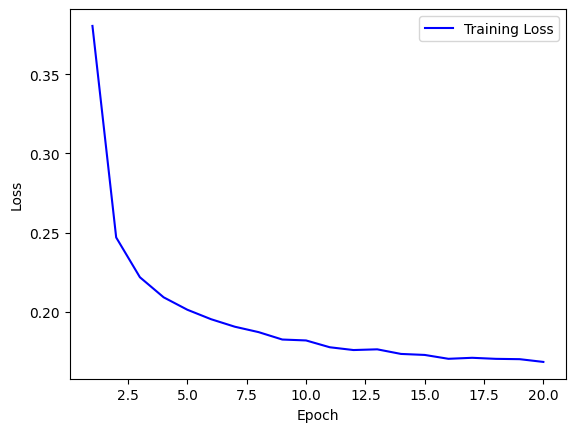

In [57]:
# Create count of the number of epochs
epoch_count = [i for i in range(1,21)]
# Visualize loss history
plt.plot(epoch_count, loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [58]:
y_pred = model.predict(X_test)
y_pred_label = y_pred >= 0.5

413/413 [==============================] - 230s 552ms/step


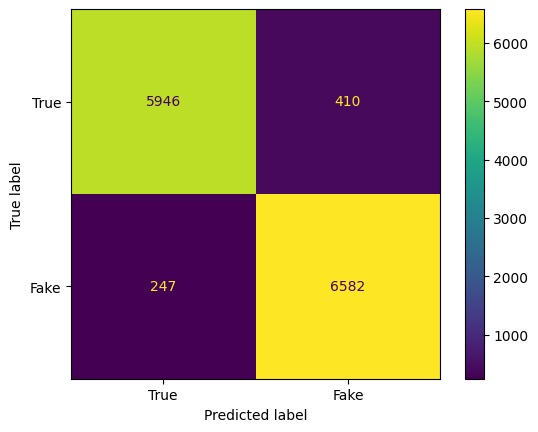

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusionMatrix = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix,display_labels=categories)
disp.plot()

In [60]:
from sklearn.metrics import precision_recall_fscore_support
metrics  = precision_recall_fscore_support(y_test, y_pred_label, average='macro')
print("Macro Precsion on Test Set:",metrics[0])
print("Macro Recall on Test Set:",metrics[1])
print("Macro F1 Score on Test Set:",metrics[2])

Macro Precsion on Test Set: 0.9507389081789768
Macro Recall on Test Set: 0.9496623716591617
Macro F1 Score on Test Set: 0.9500544364895773
